In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from uuid import uuid4

import pandas as pd
import numpy as np
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from tqdm.auto import tqdm
import torch

sys.path.append("..")
from sgs_utils.path_conf import (
    loc_data_dir,
    speech_data_root_dir,
    speech_data_session_dir,
)

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/torchaudio/_internal/module_utils.py:87: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


In [4]:
df_session = pd.read_parquet(loc_data_dir.joinpath("df_session_uuid.parquet"))

In [5]:
extracted_embeddings = False

# Use the `ECAPA-TDNN` architecture to extract embeddings

In [45]:
if not extracted_embeddings:
    # load the ECAPA-TDNN classifier
    classifier = EncoderClassifier.from_hparams(
        source="speechbrain/spkrec-ecapa-voxceleb"
    )

    if torch.cuda.is_available():
        print(torch.cuda.get_device_name())
        classifier = classifier.cuda()
        classifier.device = f'cuda:{torch.cuda.current_device()}'
        print(classifier.device)

    uuid_embedding = {}

    for _, row in tqdm(list(df_session.iterrows())):
        signal, fs = torchaudio.load(
            list(
                list(speech_data_session_dir.glob(f"*{row.ID}*"))[0]
                .joinpath(row.DB)
                .glob(f"*{row.time_str}*.wav")
            )[0],
            channels_first=False,
        )
        if signal.size()[0] == 0:
            continue
        # Note: `classifier.audio_normalize` withholds the logic to normalize the audio to the
        # desired format of the ECAPA-TDNN architecture
        uuid_embedding[row.uuid] = (
            classifier.encode_batch(classifier.audio_normalizer(signal, fs))
            .cpu()
            .numpy()
            .ravel()
        )

    df_emb = pd.DataFrame(uuid_embedding).T.add_prefix("emb_")
    df_emb.index.name = "uuid"
    df_emb.index = df_emb.index.astype("str")
    del row, signal, fs, uuid_embedding

    df_emb.to_parquet(loc_data_dir.joinpath("uuid_emb.parquet"))

else:
    df_emb = pd.read_parquet(loc_data_dir.joinpath("uuid_emb.parquet"))

Tesla V100-SXM3-32GB
cuda:0


  0%|          | 0/1147 [00:00<?, ?it/s]

# Merge the embeddings with the session data

In [ ]:
df_tot = pd.merge(df_session, df_emb.reset_index(), on=["uuid"])
df_tot

,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,pic_name,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
0,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,marloes,...,-7.108462,12.071759,13.764293,-1.152341,-19.221691,11.216937,-2.520956,14.563152,29.833792,4.312584
1,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Picture 105,...,-11.329021,6.115950,31.284130,27.954729,-7.563587,29.465137,5.591846,14.258327,10.912828,4.384000
2,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Rafd090_24_Caucasian_male_neutral_frontal,...,-26.330029,-5.139014,38.220718,15.530747,-2.335438,3.851444,-1.272245,7.434909,4.015082,-15.379341
3,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Picture 82,...,4.303907,20.435778,25.857258,17.855587,-5.828009,9.242099,23.921473,7.689355,34.666237,18.014540
4,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Rafd090_33_Caucasian_male_neutral_frontal,...,-5.603482,12.006293,33.583046,8.054259,1.245833,-5.431383,14.768442,5.772885,28.125568,0.537862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 80,...,-21.482920,27.795383,-39.391003,14.513511,18.173933,-19.711971,-3.821519,-6.437912,-23.122728,9.666114
1131,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Rafd090_36_Caucasian_male_neutral_frontal,...,-6.808078,21.008301,-39.891216,22.018456,19.344872,-17.532473,8.937423,2.978307,-21.796740,2.103682
1132,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 105,...,-22.812557,24.275753,-36.314835,18.945406,19.262991,-26.497667,6.591322,-1.799543,-24.474586,10.668746
1133,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Rafd090_01_Caucasian_female_neutral_frontal,...,-21.230860,21.326643,-36.082150,16.821028,17.867605,-6.244761,3.824244,-1.546602,-25.649057,7.933519


In [ ]:
df_tot["speech_style"] = df_tot.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

In [ ]:
df_tot.filter(like="emb_").head(n=3)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
0,-29.735405,28.870438,-7.721367,-2.163667,15.799292,-12.133623,4.848155,15.863817,32.329281,-4.506698,...,-7.108462,12.071759,13.764293,-1.152341,-19.221691,11.216937,-2.520956,14.563152,29.833792,4.312584
1,-27.537544,8.651312,-7.450600,-2.576167,10.251889,-10.824502,21.282038,29.855700,30.608700,-13.781232,...,-11.329021,6.115950,31.284130,27.954729,-7.563587,29.465137,5.591846,14.258327,10.912828,4.384000
2,-26.542959,-2.001475,-7.376130,8.859022,16.296432,-28.526539,14.828303,40.838436,3.677012,-14.097699,...,-26.330029,-5.139014,38.220718,15.530747,-2.335438,3.851444,-1.272245,7.434909,4.015082,-15.379341


# Data analysis - `TSNE`

use the `TSNE` decomposition for analysing the lower dimensional representations of the embeddings.

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# We want to get TSNE embeddings with 2 dimensions
n_components = 2
tsne = TSNE(n_components, perplexity=100)  # perplexity = # allowed nearest neighbours
tsne_result = tsne.fit_transform(df_tot.filter(like="emb_"))


def construct_tsne_df(tnse_result: np.ndarray, label_col: str) -> pd.DataFrame:
    tsne_result_df = pd.DataFrame(tsne_result).add_prefix("tsne_")
    tsne_result_df[label_col] = df_tot[label_col]
    return tsne_result_df

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Visualize TSNE

In [ ]:
import seaborn as sns
sns.set_context('talk')

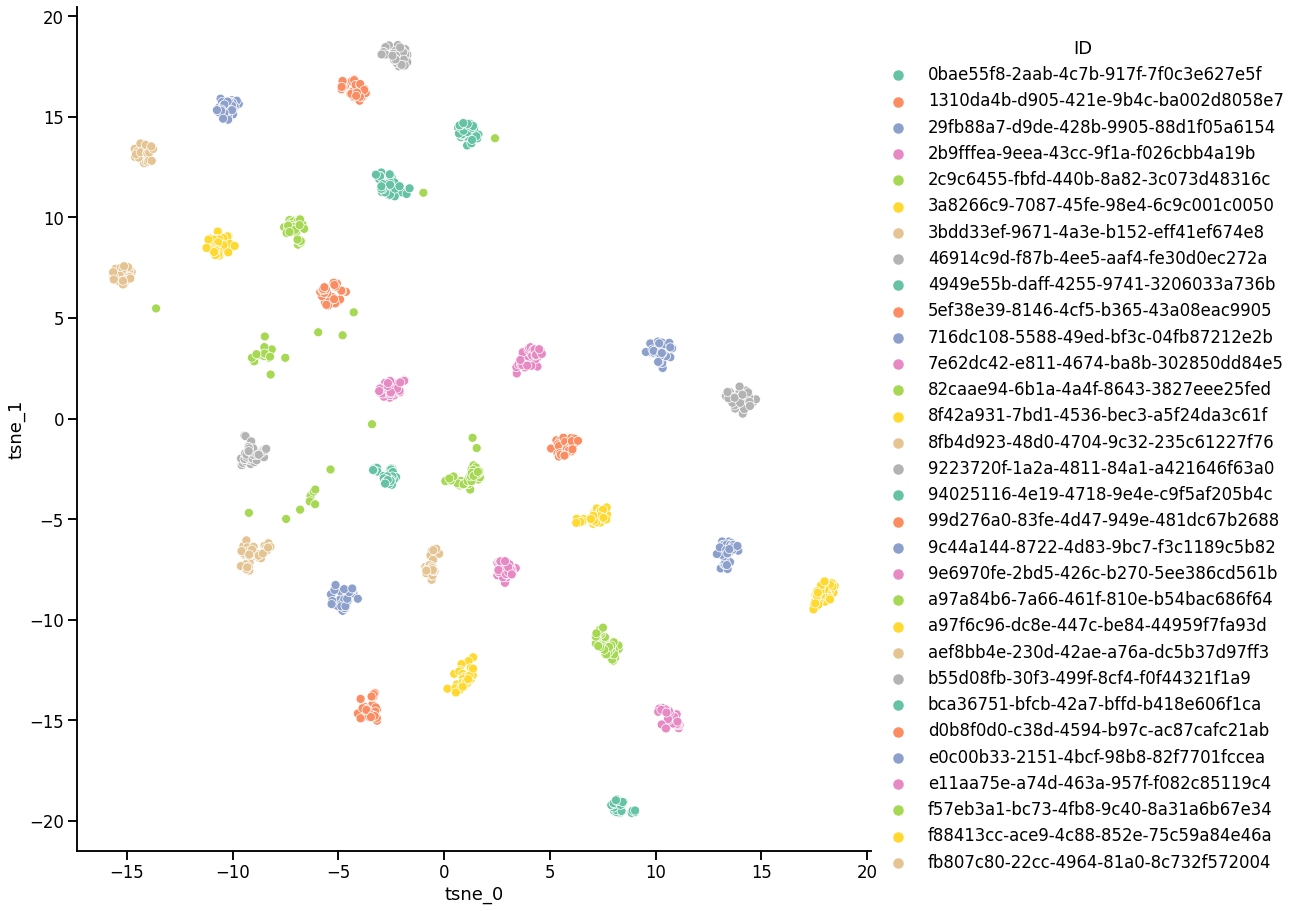

In [ ]:
label_col = 'ID'
sns.relplot(
    data=construct_tsne_df(tsne_result, label_col=label_col),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
)

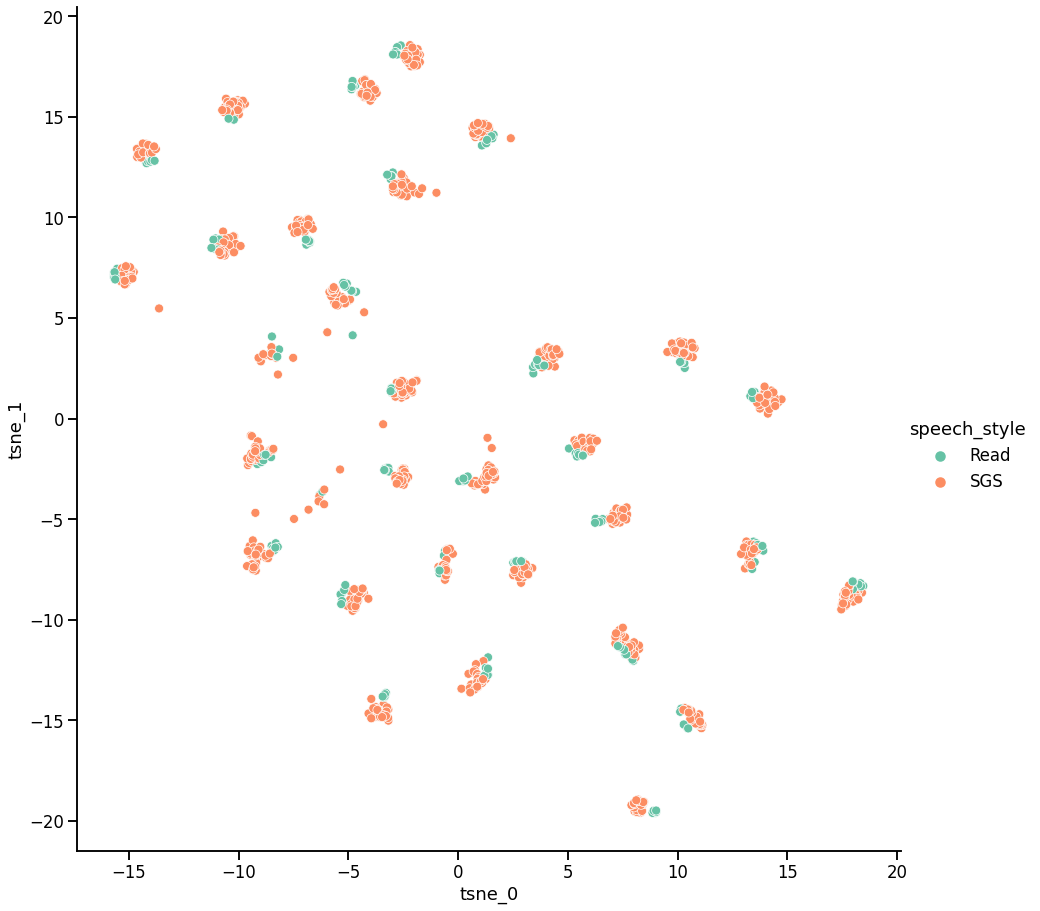

In [ ]:
label_col = "speech_style"
sns.relplot(
    data=construct_tsne_df(tsne_result, label_col=label_col),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
)

# Testing `speech-style` seperability 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt

In [ ]:
df_tot["speech_style"].values

array(['Read', 'SGS', 'SGS', ..., 'SGS', 'SGS', 'Read'], dtype=object)

In [ ]:
model = Pipeline(
    [
        # ("scaling", RobustScaler()),
        ("scaling", PowerTransformer()),
        # ('lda', LinearDiscriminantAnalysis(tol=1e-1)),
        # ("lr", LogisticRegression(C=1))
        ("lr", LogisticRegression(C=1)),# class_weight='balanced'))
        # (
        #     "rf",
        #     RandomForestClassifier(
        #         class_weight="balanced",
        #         max_depth=3, max_samples=.5
        #     ),
        # )
    ]
)

cross_val_score(
    estimator=model,
    X=df_tot.filter(like="emb_"),
    y=df_tot["speech_style"],
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=df_tot["ID"],
)

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


array([0.81927398, 0.78028342, 0.72108939, 0.79983649, 0.74390244])

In [ ]:
X = df_tot.filter(like="emb_").values
y = df_tot["speech_style"].values
groups = df_tot["ID"]

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


              precision    recall  f1-score   support

        Read       0.39      0.98      0.56        46
         SGS       0.99      0.66      0.79       209

    accuracy                           0.72       255
   macro avg       0.69      0.82      0.67       255
weighted avg       0.88      0.72      0.75       255



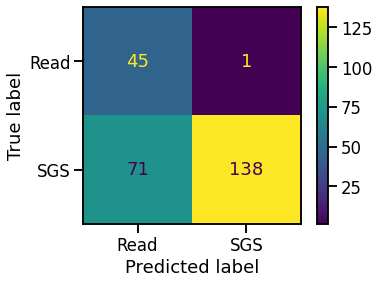

              precision    recall  f1-score   support

        Read       0.47      0.76      0.58        41
         SGS       0.94      0.80      0.86       179

    accuracy                           0.80       220
   macro avg       0.70      0.78      0.72       220
weighted avg       0.85      0.80      0.81       220



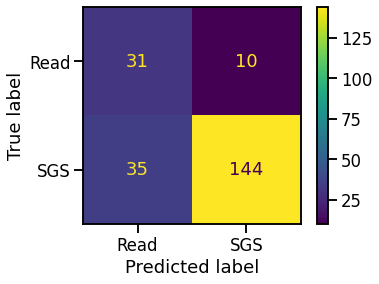

              precision    recall  f1-score   support

        Read       0.32      0.85      0.46        40
         SGS       0.95      0.59      0.73       179

    accuracy                           0.64       219
   macro avg       0.63      0.72      0.60       219
weighted avg       0.83      0.64      0.68       219



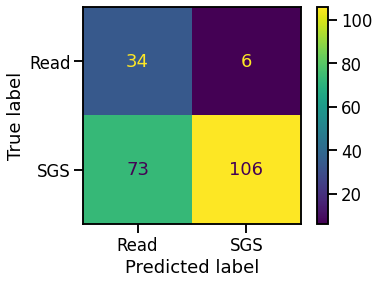

              precision    recall  f1-score   support

        Read       0.53      0.76      0.62        41
         SGS       0.94      0.84      0.89       179

    accuracy                           0.83       220
   macro avg       0.73      0.80      0.75       220
weighted avg       0.86      0.83      0.84       220



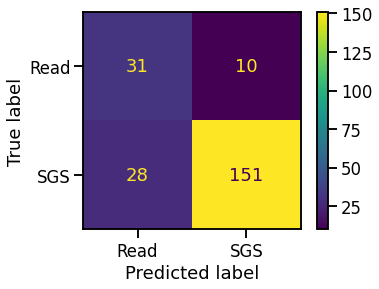

              precision    recall  f1-score   support

        Read       1.00      0.49      0.66        41
         SGS       0.90      1.00      0.94       180

    accuracy                           0.90       221
   macro avg       0.95      0.74      0.80       221
weighted avg       0.91      0.90      0.89       221



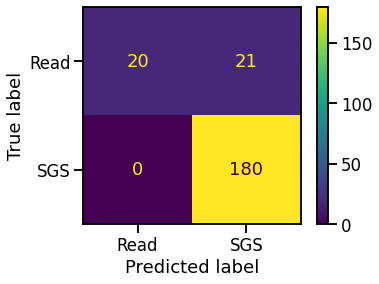

In [ ]:
mf1s = []
aps = []
aucs = []
kf = StratifiedGroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X[train_idx, :]
    x_test_cv_ = X[test_idx, :]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    preds_proba = model.predict_proba(x_test_cv_)[:, 1]
    mf1s += [f1_score(y[test_idx], preds, average="macro")]
    print(classification_report(y[test_idx], preds))
    ConfusionMatrixDisplay.from_estimator(model, x_test_cv_, y[test_idx])
    plt.show()
    # aps += [average_precision_score(y[test_idx], preds_proba)]
    # aucs += [roc_auc_score(y[test_idx], preds_proba)]

# Fixed duration

In [110]:
DUR_S = 15


# load the ECAPA-TDNN classifier
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb"
)

if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    classifier = classifier.cuda()
    classifier.device = f'cuda:{torch.cuda.current_device()}'
    print(classifier.device)

uuid_embedding = {}

for _, row in tqdm(list(df_session.iterrows())):
    signal, fs = torchaudio.load(
        list(
            list(speech_data_session_dir.glob(f"*{row.ID}*"))[0]
            .joinpath(row.DB)
            .glob(f"*{row.time_str}*.wav")
        )[0],
        channels_first=False,
    )
    # slice the signal to the correct duration
    if signal.size()[0] < fs * DUR_S:
        continue
    signal = signal[:fs*DUR_S]

    # Note: `classifier.audio_normalize` withholds the logic to normalize the audio to the
    # desired format of the ECAPA-TDNN architecture
    uuid_embedding[row.uuid] = (
        classifier.encode_batch(classifier.audio_normalizer(signal, fs))
        .cpu()
        .numpy()
        .ravel()
    )

df_emb_fixed_dur = pd.DataFrame(uuid_embedding).T.add_prefix("emb_")
df_emb_fixed_dur.index.name = "uuid"
df_emb_fixed_dur.index = df_emb_fixed_dur.index.astype("str")
del row, signal, fs, uuid_embedding

Tesla V100-SXM3-32GB
cuda:0


  0%|          | 0/1147 [00:00<?, ?it/s]

In [70]:
df_emb_fixed_dur.head(2)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
uuid,,,,,,,,,,,,,,,,,,,,,
584871ea-39d4-41fe-80f4-1f602bab38f6,-29.063700,26.635309,-10.448268,0.812526,19.744749,-3.109807,4.905005,20.307962,36.513783,-7.222564,...,-2.723156,10.154124,11.299281,-1.717048,-22.060354,2.620439,-0.631572,16.782021,32.057259,1.362354
206f620d-6c5e-48fd-adff-f44aa4fbb48c,-30.698008,24.810972,-7.990213,-8.441961,5.330547,-22.003922,-0.075038,16.848347,30.071709,-7.995103,...,-6.304168,10.011980,31.299200,22.109964,4.298169,12.647592,-1.532890,20.230885,2.061954,-6.015813


## Merge the embeddings with the session data

In [73]:
df_tot_fd = pd.merge(df_session, df_emb_fixed_dur.reset_index(), on=["uuid"])
df_tot_fd.head()

,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,pic_name,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
0,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,marloes,...,-2.723156,10.154124,11.299281,-1.717048,-22.060354,2.620439,-0.631572,16.782021,32.057259,1.362354
1,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Picture 105,...,-6.304168,10.011980,31.299200,22.109964,4.298169,12.647592,-1.532890,20.230885,2.061954,-6.015813
2,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Rafd090_24_Caucasian_male_neutral_frontal,...,-16.984837,-14.575746,28.605106,3.857569,-5.655838,1.753878,-1.631925,2.233550,-1.369304,-26.862740
3,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Picture 82,...,4.581734,19.547592,36.713665,-3.709904,5.409800,6.687357,21.007305,12.380856,13.920447,-1.297993
4,29,unif,female,2020-11-27 20:02:22.592132+01:00,0bae55f8-2aab-4c7b-917f-7f0c3e627e5f,7,15,15,None,Rafd090_33_Caucasian_male_neutral_frontal,...,-15.412704,1.149072,22.867840,21.977064,4.713783,-0.932730,13.794068,-10.198920,20.102268,-4.242955


In [89]:
df_tot_fd["speech_style"] = df_tot_fd.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "SGS", "Radboud": "SGS"}.get(x)
)

In [90]:
df_tot_fd.filter(like="emb_").head(n=3)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_182,emb_183,emb_184,emb_185,emb_186,emb_187,emb_188,emb_189,emb_190,emb_191
0,-29.063700,26.635309,-10.448268,0.812526,19.744749,-3.109807,4.905005,20.307962,36.513783,-7.222564,...,-2.723156,10.154124,11.299281,-1.717048,-22.060354,2.620439,-0.631572,16.782021,32.057259,1.362354
1,-30.698008,24.810972,-7.990213,-8.441961,5.330547,-22.003922,-0.075038,16.848347,30.071709,-7.995103,...,-6.304168,10.011980,31.299200,22.109964,4.298169,12.647592,-1.532890,20.230885,2.061954,-6.015813
2,-31.045332,-6.535282,-19.175699,1.887115,32.980679,-25.353420,16.675098,31.793787,-3.207250,-12.762577,...,-16.984837,-14.575746,28.605106,3.857569,-5.655838,1.753878,-1.631925,2.233550,-1.369304,-26.862740


# Data analysis - `TSNE`

use the `TSNE` decomposition for analysing the lower dimensional representations of the embeddings.

In [91]:
from sklearn.manifold import TSNE

In [84]:
# We want to get TSNE embeddings with 2 dimensions
n_components = 2
tsne = TSNE(n_components, perplexity=100)  # perplexity = # allowed nearest neighbours
tsne_result_fd = tsne.fit_transform(df_tot_fd.filter(like="emb_"))


def construct_tsne_df(tnse_result: np.ndarray, label_col: str) -> pd.DataFrame:
    tsne_result_df = pd.DataFrame(tnse_result).add_prefix("tsne_")
    tsne_result_df[label_col] = df_tot_fd[label_col]
    return tsne_result_df

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Visualize TSNE

In [86]:
import seaborn as sns
sns.set_context('talk')

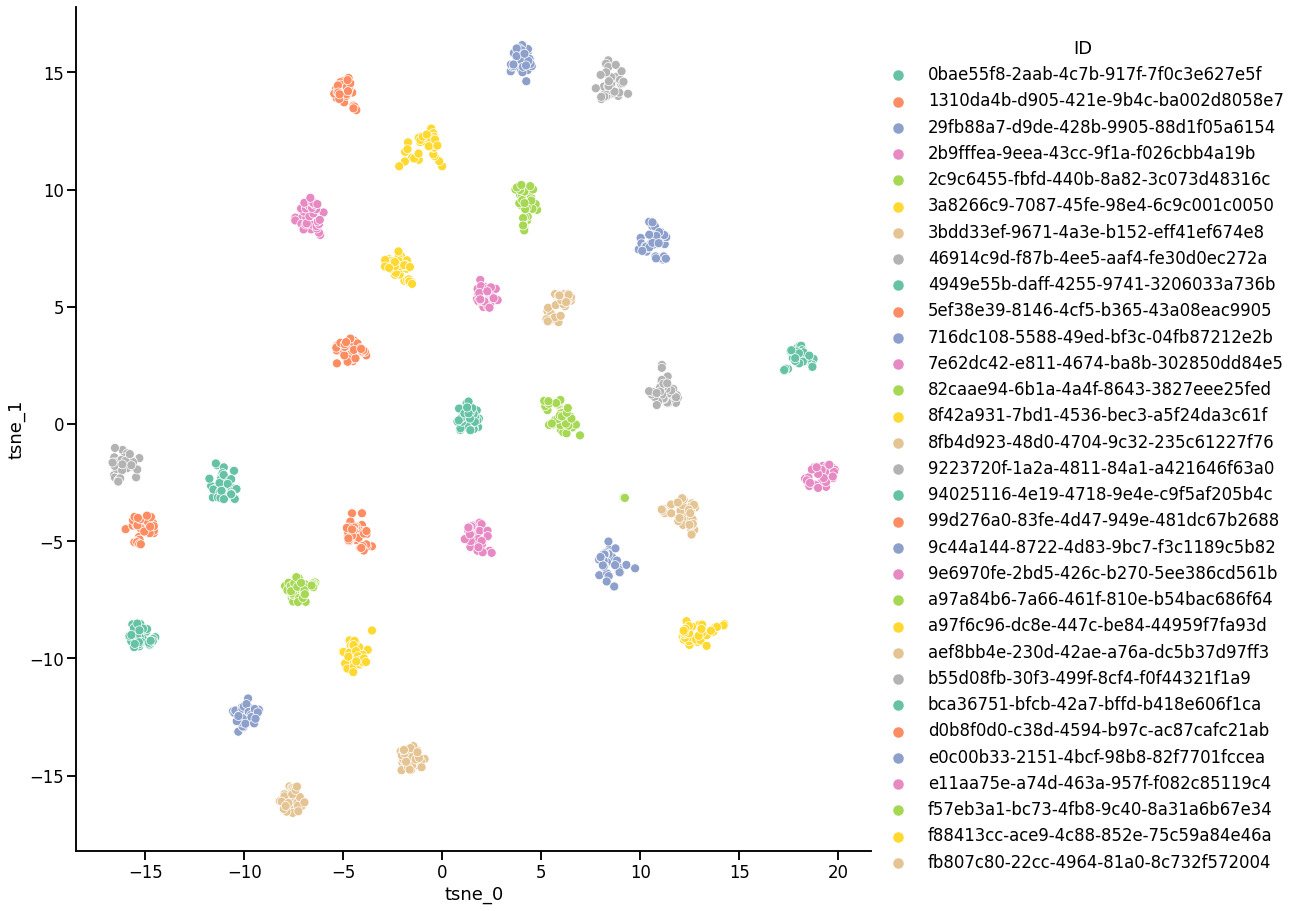

In [87]:
label_col = 'ID'
sns.relplot(
    data=construct_tsne_df(tsne_result_fd, label_col=label_col),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
)

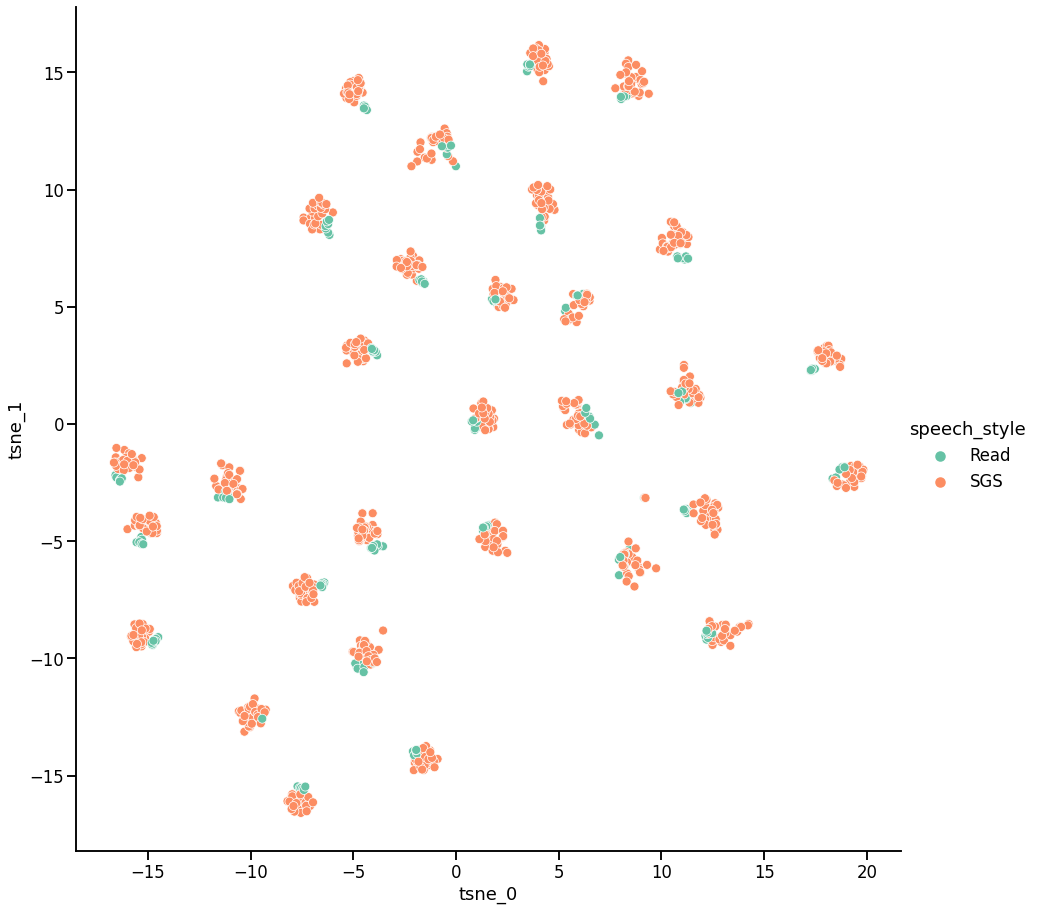

In [92]:
label_col = "speech_style"
sns.relplot(
    data=construct_tsne_df(tsne_result_fd, label_col=label_col),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
)

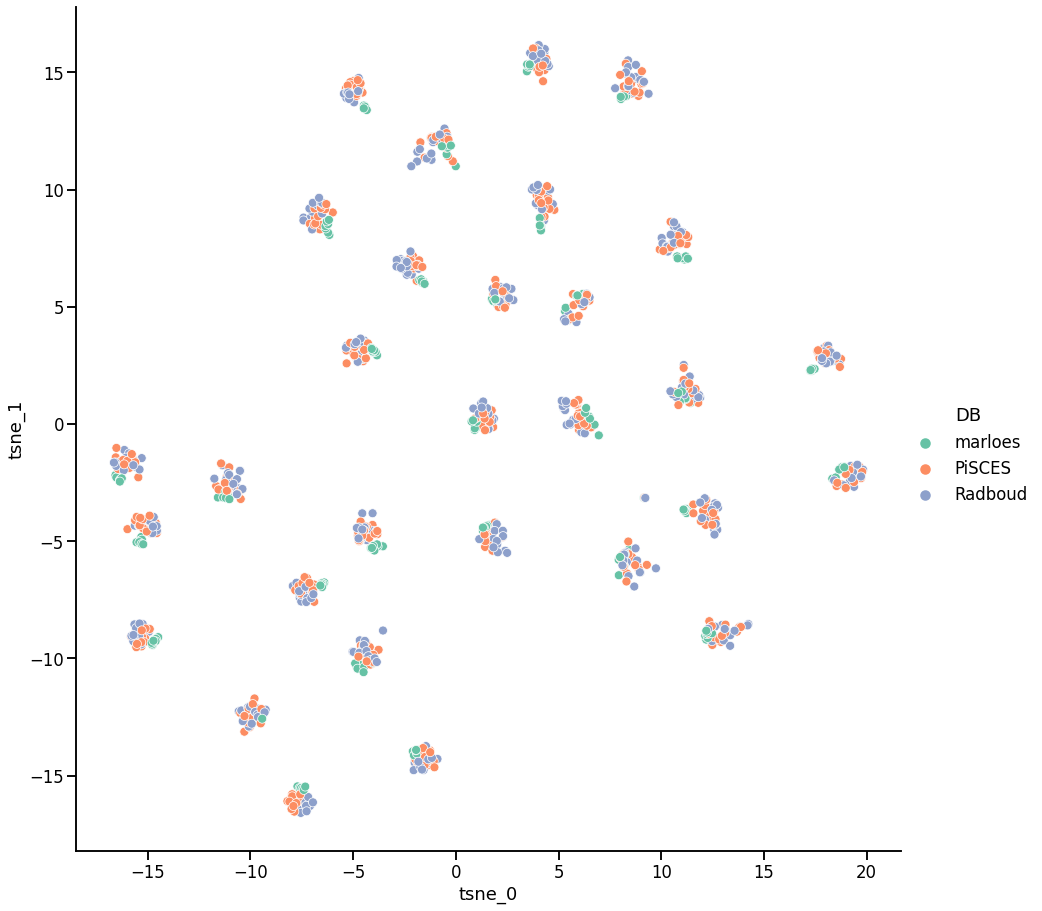

In [108]:
label_col = "DB"
sns.relplot(
    data=construct_tsne_df(tsne_result_fd, label_col=label_col),
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    height=13,
    kind="scatter",
    palette="Set2",
    aspect=1,
)

# Testing `speech-style` seperability 

In [93]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    cross_validate,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt

In [94]:
df_tot_fd["speech_style"].values

array(['Read', 'SGS', 'SGS', ..., 'SGS', 'SGS', 'Read'], dtype=object)

In [103]:
from sklearn.decomposition import PCA

In [109]:
model = Pipeline(
    [
        # ("scaling", RobustScaler()),
        ("scaling", PowerTransformer()),
        # ('lda', LinearDiscriminantAnalysis(tol=1e-1)),
        # ("lr", LogisticRegression(C=1))
        # ("pca", PCA()),
        ("lr", LogisticRegression(C=1)),# class_weight='balanced'))
        # (
        #     "rf",
        #     RandomForestClassifier(
        #         # class_weight="balanced",
        #         max_depth=3, max_samples=.5
        #     ),
        # )
    ]
)

cross_val_score(
    estimator=model,
    X=df_tot_fd.filter(like="emb_"),
    y=df_tot_fd["DB"],
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=df_tot_fd["ID"],
)

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

array([0.47241555, 0.63782772, 0.54944344, 0.65865262, 0.57157551])

In [106]:
X = df_tot_fd.filter(like="emb_").values
y = df_tot_fd["speech_style"].values
groups = df_tot_fd["ID"]

              precision    recall  f1-score   support

        Read       0.83      0.60      0.70        40
         SGS       0.92      0.97      0.94       178

    accuracy                           0.90       218
   macro avg       0.87      0.79      0.82       218
weighted avg       0.90      0.90      0.90       218



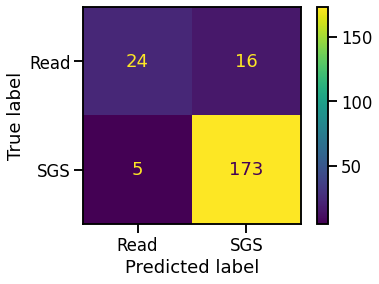

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


              precision    recall  f1-score   support

        Read       0.61      0.93      0.74        41
         SGS       0.98      0.87      0.92       178

    accuracy                           0.88       219
   macro avg       0.80      0.90      0.83       219
weighted avg       0.91      0.88      0.89       219



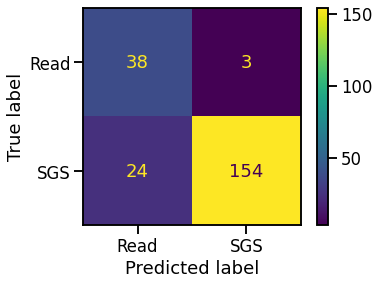

              precision    recall  f1-score   support

        Read       0.72      0.78      0.75        40
         SGS       0.95      0.93      0.94       181

    accuracy                           0.90       221
   macro avg       0.84      0.85      0.84       221
weighted avg       0.91      0.90      0.91       221



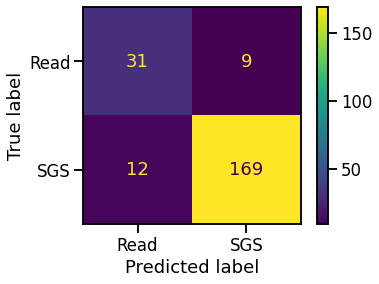

              precision    recall  f1-score   support

        Read       0.31      0.70      0.43        40
         SGS       0.91      0.66      0.76       178

    accuracy                           0.67       218
   macro avg       0.61      0.68      0.60       218
weighted avg       0.80      0.67      0.70       218



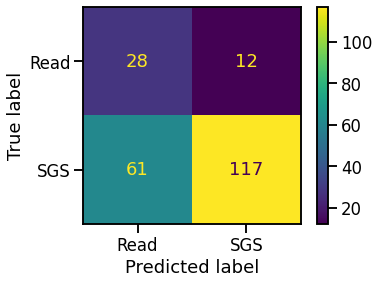

/root/.cache/pypoetry/virtualenvs/semi-guided-speech-irC9fLWQ-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


              precision    recall  f1-score   support

        Read       0.64      0.83      0.72        41
         SGS       0.96      0.89      0.92       178

    accuracy                           0.88       219
   macro avg       0.80      0.86      0.82       219
weighted avg       0.90      0.88      0.89       219



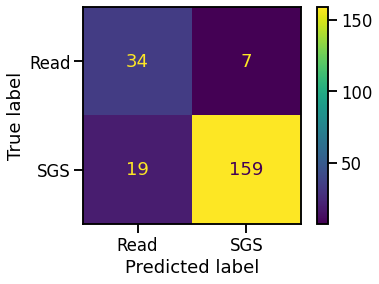

In [107]:
mf1s = []
aps = []
aucs = []
kf = StratifiedGroupKFold(n_splits=5)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X[train_idx, :]
    x_test_cv_ = X[test_idx, :]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    preds_proba = model.predict_proba(x_test_cv_)[:, 1]
    mf1s += [f1_score(y[test_idx], preds, average="macro")]
    print(classification_report(y[test_idx], preds))
    ConfusionMatrixDisplay.from_estimator(model, x_test_cv_, y[test_idx])
    plt.show()
    # aps += [average_precision_score(y[test_idx], preds_proba)]
    # aucs += [roc_auc_score(y[test_idx], preds_proba)]